# Modeling of the clustered data

Portugal municipaliaties are incredibly diverse, specially outside of the 2 big urban centers, such as Lisbon and Porto. So for modeling, we decided to pick the clusters created before, where the 2 big cities are not included. From the modeling experiments before, we decided to follow with Gradient Boosting Regressor and Elasctic Net Regressor. Since in their class were the best perofrming ones, and we wanted to compare their approach with one another.

To perform the modelling, we trained the models with the data of each cluster, and they were trained in the data from 2019-2022 and tested in the 2023 data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import joblib

from src.config import (
    RANDOM_SEED,
    MODELS_DIR,
    MUNICIPALITY_COLUMN,
    URBAN_CLUSTER_FILE,
    CLUSTER_LABELS,
    REGRESSION_FEATURES,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES
)

In [2]:
df_master = pd.read_csv(URBAN_CLUSTER_FILE)
target_column = "log_price_sqm"

feature_cols = REGRESSION_FEATURES["numerical"] + REGRESSION_FEATURES["categorical"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), REGRESSION_FEATURES["numerical"]),
        ("cat", "passthrough", REGRESSION_FEATURES["categorical"]),
    ],
    remainder="drop",
)

selected_clusters = [0, 1, 4]

## What Might Influence House Prices?

Our intent is to find the factors that influence the price of houses, empiraclly, one could say, that the factors that influence the house market are population density, income, and the number of jobs. But we decided to take a deeper look, and understand in detail the factors that influence the price of a house.

Our feature set includes weather patterns (sunshine, rain, wind), urban services (hospitals, schools, cultural spaces), demographics (age distribution), economic indicators (average income), and the urban cluster assignments we created earlier. Each municipality is a unique combination of these characteristics.

## Three Different Worlds

We're analyzing three clusters that emerged from our urbanization analysis:

**Cluster 0 - Rural municipalities**: Lower density, fewer services, more dispersed populations. These are places where nature and space might be the real amenities.

**Cluster 1 - Suburban areas**: The middle ground. Moderate density with decent service access, but not quite the urban intensity.

**Cluster 4 - Urban centers**: High density with extensive infrastructure—hospitals, universities, cultural venues all within reach.

The key question: does a hospital matter as much in a rural area as it does downtown? Does weather play a bigger role when there's less entertainment infrastructure? By modeling each cluster separately, we can find out.

In [3]:
model_configs = {
    "elasticnet": {"class": ElasticNet, "params": {"alpha": 0.1, "l1_ratio": 0.5, "random_state": RANDOM_SEED, "max_iter": 5000}},
    "gbm": {"class": GradientBoostingRegressor, "params": {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.1, "random_state": RANDOM_SEED, "subsample": 0.8, "max_features": "sqrt"}},
}

## Two Ways of Looking at the Same Question

We're using two different models because they have different approaches and we think they are interesting:

- **Elastic Net** is a linear regression model that combines L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting and handle correlated features. By shrinking and possibly zeroing some coefficients, it performs feature selection while keeping the model relatively simple and interpretable.

- **Gradient Boosting Regressor** is an ensemble method that builds a sequence of decision trees, where each new tree focuses on correcting the errors of the previous ones. By combining many weak learners into a strong model, it can capture complex non-linear relationships and often achieves high predictive performance on structured data.


In [4]:
cluster_results = {}
cluster_pipelines = {}

for cluster_id in selected_clusters:
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")

    df_cluster = df_master[df_master['cluster_urban'] == cluster_id].copy()
    df_train = df_cluster[df_cluster['year'] < 2023].copy()
    df_test = df_cluster[df_cluster['year'] == 2023].copy()
    
    if len(df_train) == 0 or len(df_test) == 0:
        continue

    X_train = df_train[feature_cols].copy()
    y_train = df_train[target_column].copy()
    groups_train = df_train[MUNICIPALITY_COLUMN].values

    X_test = df_test[feature_cols].copy()
    y_test = df_test[target_column].copy()

    valid_train = X_train.notna().all(axis=1) & y_train.notna()
    X_train = X_train[valid_train].reset_index(drop=True)
    y_train = y_train[valid_train].reset_index(drop=True)
    groups_train = groups_train[valid_train]
    
    valid_test = X_test.notna().all(axis=1) & y_test.notna()
    X_test = X_test[valid_test].reset_index(drop=True)
    y_test = y_test[valid_test].reset_index(drop=True)

    cluster_results[cluster_id] = {}
    cluster_pipelines[cluster_id] = {}

    gkf = GroupKFold(n_splits=5)
    scoring = {"r2": "r2", "neg_mse": "neg_mean_squared_error", "neg_mae": "neg_mean_absolute_error"}
    
    for model_key, config in model_configs.items():
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", config["class"](**config["params"])),
        ])

        cv_scores = cross_validate(
            pipeline, X_train, y_train,
            cv=gkf, groups=groups_train,
            scoring=scoring, return_train_score=True, n_jobs=-1
        )

        pipeline.fit(X_train, y_train)
        y_pred_test = pipeline.predict(X_test)

        test_r2 = r2_score(y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mae = mean_absolute_error(y_test, y_pred_test)

        cluster_results[cluster_id][model_key] = {
            'cv_r2_mean': cv_scores["test_r2"].mean(),
            'cv_r2_std': cv_scores["test_r2"].std(),
            'cv_rmse': np.sqrt(-cv_scores["test_neg_mse"]).mean(),
            'cv_mae': (-cv_scores["test_neg_mae"]).mean(),
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'y_test': y_test.copy(),
            'y_pred': y_pred_test.copy()
        }
        
        cluster_pipelines[cluster_id][model_key] = pipeline


## Testing Against the Future

Here’s the challenging part: we want to determine whether our understanding of the drivers of housing prices remains stable over time, rather than simply capturing patterns specific to the training data.

To test this, we train our models on 2019–2022 data using 5‑fold cross‑validation, grouped by municipality to prevent data leakage. We then evaluate model performance on 2023, which serves as a completely held‑out year. Strong performance on this test set indicates that the patterns identified by the models are not just historical coincidences but genuine, persistent drivers of housing prices.

It’s also important to note that we predict the log of price per square meter rather than raw prices. This transformation helps stabilize the distribution and makes the models more robust to extreme values.

In [5]:
results_summary = []

for cluster_id in selected_clusters:
    if cluster_id not in cluster_results:
        continue
    
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")
    
    for model_key in model_configs.keys():
        if model_key not in cluster_results[cluster_id]:
            continue
        
        metrics = cluster_results[cluster_id][model_key]
        
        results_summary.append({
            "Cluster ID": cluster_id,
            "Cluster": cluster_label,
            "Model": model_key,
            "CV R² (2019-2022)": metrics['cv_r2_mean'],
            "CV R² Std": metrics['cv_r2_std'],
            "Test R² (2023)": metrics['test_r2'],
            "CV RMSE": metrics['cv_rmse'],
            "Test RMSE (2023)": metrics['test_rmse'],
            "CV MAE": metrics['cv_mae'],
            "Test MAE (2023)": metrics['test_mae']
        })

results_df = pd.DataFrame(results_summary)
display(results_df.round(4))

MODELS_DIR.mkdir(parents=True, exist_ok=True)
results_path = MODELS_DIR / "temporal_validation_by_cluster.csv"
results_df.to_csv(results_path, index=False)


,Cluster ID,Cluster,Model,CV R² (2019-2022),CV R² Std,Test R² (2023),CV RMSE,Test RMSE (2023),CV MAE,Test MAE (2023)
0,0,Rural,elasticnet,0.2482,0.2286,0.3477,0.4210,0.4502,0.3195,0.3413
1,0,Rural,gbm,0.4704,0.1292,0.8320,0.3553,0.2285,0.2725,0.1780
2,1,Suburbs,elasticnet,0.4348,0.4693,0.7268,0.1896,0.1913,0.1711,0.1623
3,1,Suburbs,gbm,-0.1728,0.8424,0.7913,0.2731,0.1672,0.2239,0.1494
4,4,Urban,elasticnet,0.1383,0.3792,0.3985,0.3331,0.3401,0.2613,0.2879
5,4,Urban,gbm,-0.0678,0.4096,0.8240,0.3701,0.1840,0.2843,0.1429


## How Well Can We Predict Prices?

Before diving into what drives prices, let's see if our models actually work. The table below shows prediction accuracy across clusters and models. The Test R² tells us how well we can predict 2023 prices using patterns learned from 2019-2022.

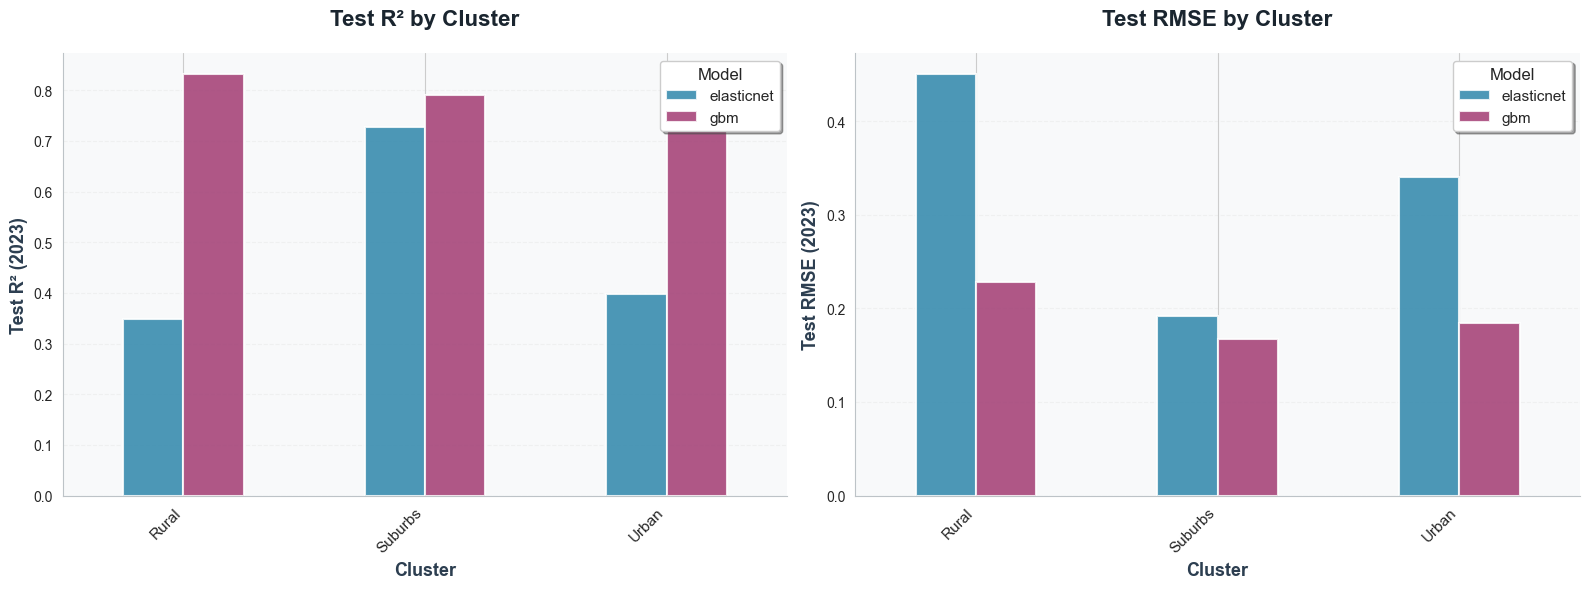

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('white')

colors = ['#2E86AB', '#A23B72']

test_r2_data = results_df.pivot(index='Cluster', columns='Model', values='Test R² (2023)')
test_r2_data.plot(kind='bar', ax=axes[0], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
axes[0].set_xlabel('Cluster', fontsize=13, fontweight='600', color='#2C3E50')
axes[0].set_ylabel('Test R² (2023)', fontsize=13, fontweight='600', color='#2C3E50')
axes[0].set_title('Test R² by Cluster', fontsize=16, fontweight='bold', color='#1A252F', pad=20)
axes[0].legend(title='Model', fontsize=11, title_fontsize=12, frameon=True, shadow=True, fancybox=True)
axes[0].grid(True, alpha=0.2, axis='y', linestyle='--', linewidth=0.8)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=11)
axes[0].set_facecolor('#F8F9FA')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_color('#BDC3C7')
axes[0].spines['bottom'].set_color('#BDC3C7')

test_rmse_data = results_df.pivot(index='Cluster', columns='Model', values='Test RMSE (2023)')
test_rmse_data.plot(kind='bar', ax=axes[1], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
axes[1].set_xlabel('Cluster', fontsize=13, fontweight='600', color='#2C3E50')
axes[1].set_ylabel('Test RMSE (2023)', fontsize=13, fontweight='600', color='#2C3E50')
axes[1].set_title('Test RMSE by Cluster', fontsize=16, fontweight='bold', color='#1A252F', pad=20)
axes[1].legend(title='Model', fontsize=11, title_fontsize=12, frameon=True, shadow=True, fancybox=True)
axes[1].grid(True, alpha=0.2, axis='y', linestyle='--', linewidth=0.8)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=11)
axes[1].set_facecolor('#F8F9FA')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_color('#BDC3C7')
axes[1].spines['bottom'].set_color('#BDC3C7')

plt.tight_layout()
plt.show()


Gradient Boosting clearly outperforms Elastic Net on 2023 data across all clusters. In the rural cluster, Elastic Net reaches an R2R2 of about 0.35 with RMSE ≈ 0.45, while Gradient Boosting achieves R2R2 ≈ 0.83 and RMSE ≈ 0.23. In the suburbs, Elastic Net attains R2R2 ≈ 0.72 and RMSE ≈ 0.19, compared to Gradient Boosting with R2R2 ≈ 0.79 and RMSE ≈ 0.17. In urban areas, Elastic Net yields R2R2 ≈ 0.40 and RMSE ≈ 0.34, whereas Gradient Boosting improves performance to R2R2 ≈ 0.72 and RMSE ≈ 0.18.

In [7]:
feature_importance_data = []

for cluster_id in selected_clusters:
    if cluster_id not in cluster_pipelines:
        continue
    
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")
    
    for model_key, pipeline in cluster_pipelines[cluster_id].items():
        regressor = pipeline.named_steps['regressor']
        feature_names = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
        
        if model_key == 'elasticnet':
            importances = np.abs(regressor.coef_)
        elif model_key == 'gbm':
            importances = regressor.feature_importances_
        
        for feat_name, importance in zip(feature_names, importances):
            feature_importance_data.append({
                'Cluster ID': cluster_id,
                'Cluster': cluster_label,
                'Model': model_key,
                'Feature': feat_name,
                'Importance': importance
            })

importance_df = pd.DataFrame(feature_importance_data)

importance_path = MODELS_DIR / "feature_importance_by_cluster.csv"
importance_df.to_csv(importance_path, index=False)


## Finally: What Actually Drives House Prices?

After training the models, we can now take a look at the actual data that drives the housing prices. So let's take a look at the feature importance of the different models.

In [8]:
for cluster_id in selected_clusters:
    if cluster_id not in cluster_pipelines:
        continue
    
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")
    
    for model_key in model_configs.keys():
        if model_key not in cluster_pipelines[cluster_id]:
            continue
        
        cluster_model_df = importance_df[
            (importance_df['Cluster ID'] == cluster_id) & 
            (importance_df['Model'] == model_key)
        ].sort_values('Importance', ascending=False).head(10)
        
        display(cluster_model_df[['Feature', 'Importance']].reset_index(drop=True))

,Feature,Importance
0,warm_days,0.044129
1,windspeed_mean_kmh,0.027360
2,sunny_days,0.009619
3,< 5,0.001058
4,20 - 34,0.000190
5,55 - 64,0.000143
6,35 - 54,0.000136
7,6 - 19,0.000135
8,> 65,0.000039
9,total_sunshine_h,0.000000


,Feature,Importance
0,6 - 19,0.187052
1,people/km2,0.102389
2,< 5,0.090956
3,20 - 34,0.084341
4,35 - 54,0.050377
5,55 - 64,0.042246
6,> 65,0.040586
7,school,0.037428
8,avg_income,0.035246
9,windspeed_mean_kmh,0.032514


,Feature,Importance
0,library,0.034106
1,museum,0.032466
2,avg_income,0.016488
3,police,0.014543
4,6 - 19,0.000071
5,> 65,0.000043
6,20 - 34,0.000040
7,35 - 54,0.000031
8,< 5,0.000019
9,55 - 64,0.000014


,Feature,Importance
0,> 65,0.233496
1,people/km2,0.112625
2,windspeed_mean_kmh,0.079647
3,20 - 34,0.068506
4,avg_income,0.067024
5,6 - 19,0.055193
6,35 - 54,0.043505
7,fire_station,0.038334
8,police,0.035651
9,kindergarten,0.029630


,Feature,Importance
0,cinema,0.091730
1,avg_income,0.070266
2,windspeed_mean_kmh,0.052863
3,mall,0.045482
4,fire_station,0.005111
5,< 5,0.000472
6,20 - 34,0.000110
7,6 - 19,0.000089
8,35 - 54,0.000054
9,55 - 64,0.000043


,Feature,Importance
0,people/km2,0.125759
1,< 5,0.083978
2,20 - 34,0.081451
3,6 - 19,0.078247
4,> 65,0.075305
5,school,0.059608
6,avg_income,0.052251
7,station,0.047781
8,35 - 54,0.043654
9,mall,0.042704


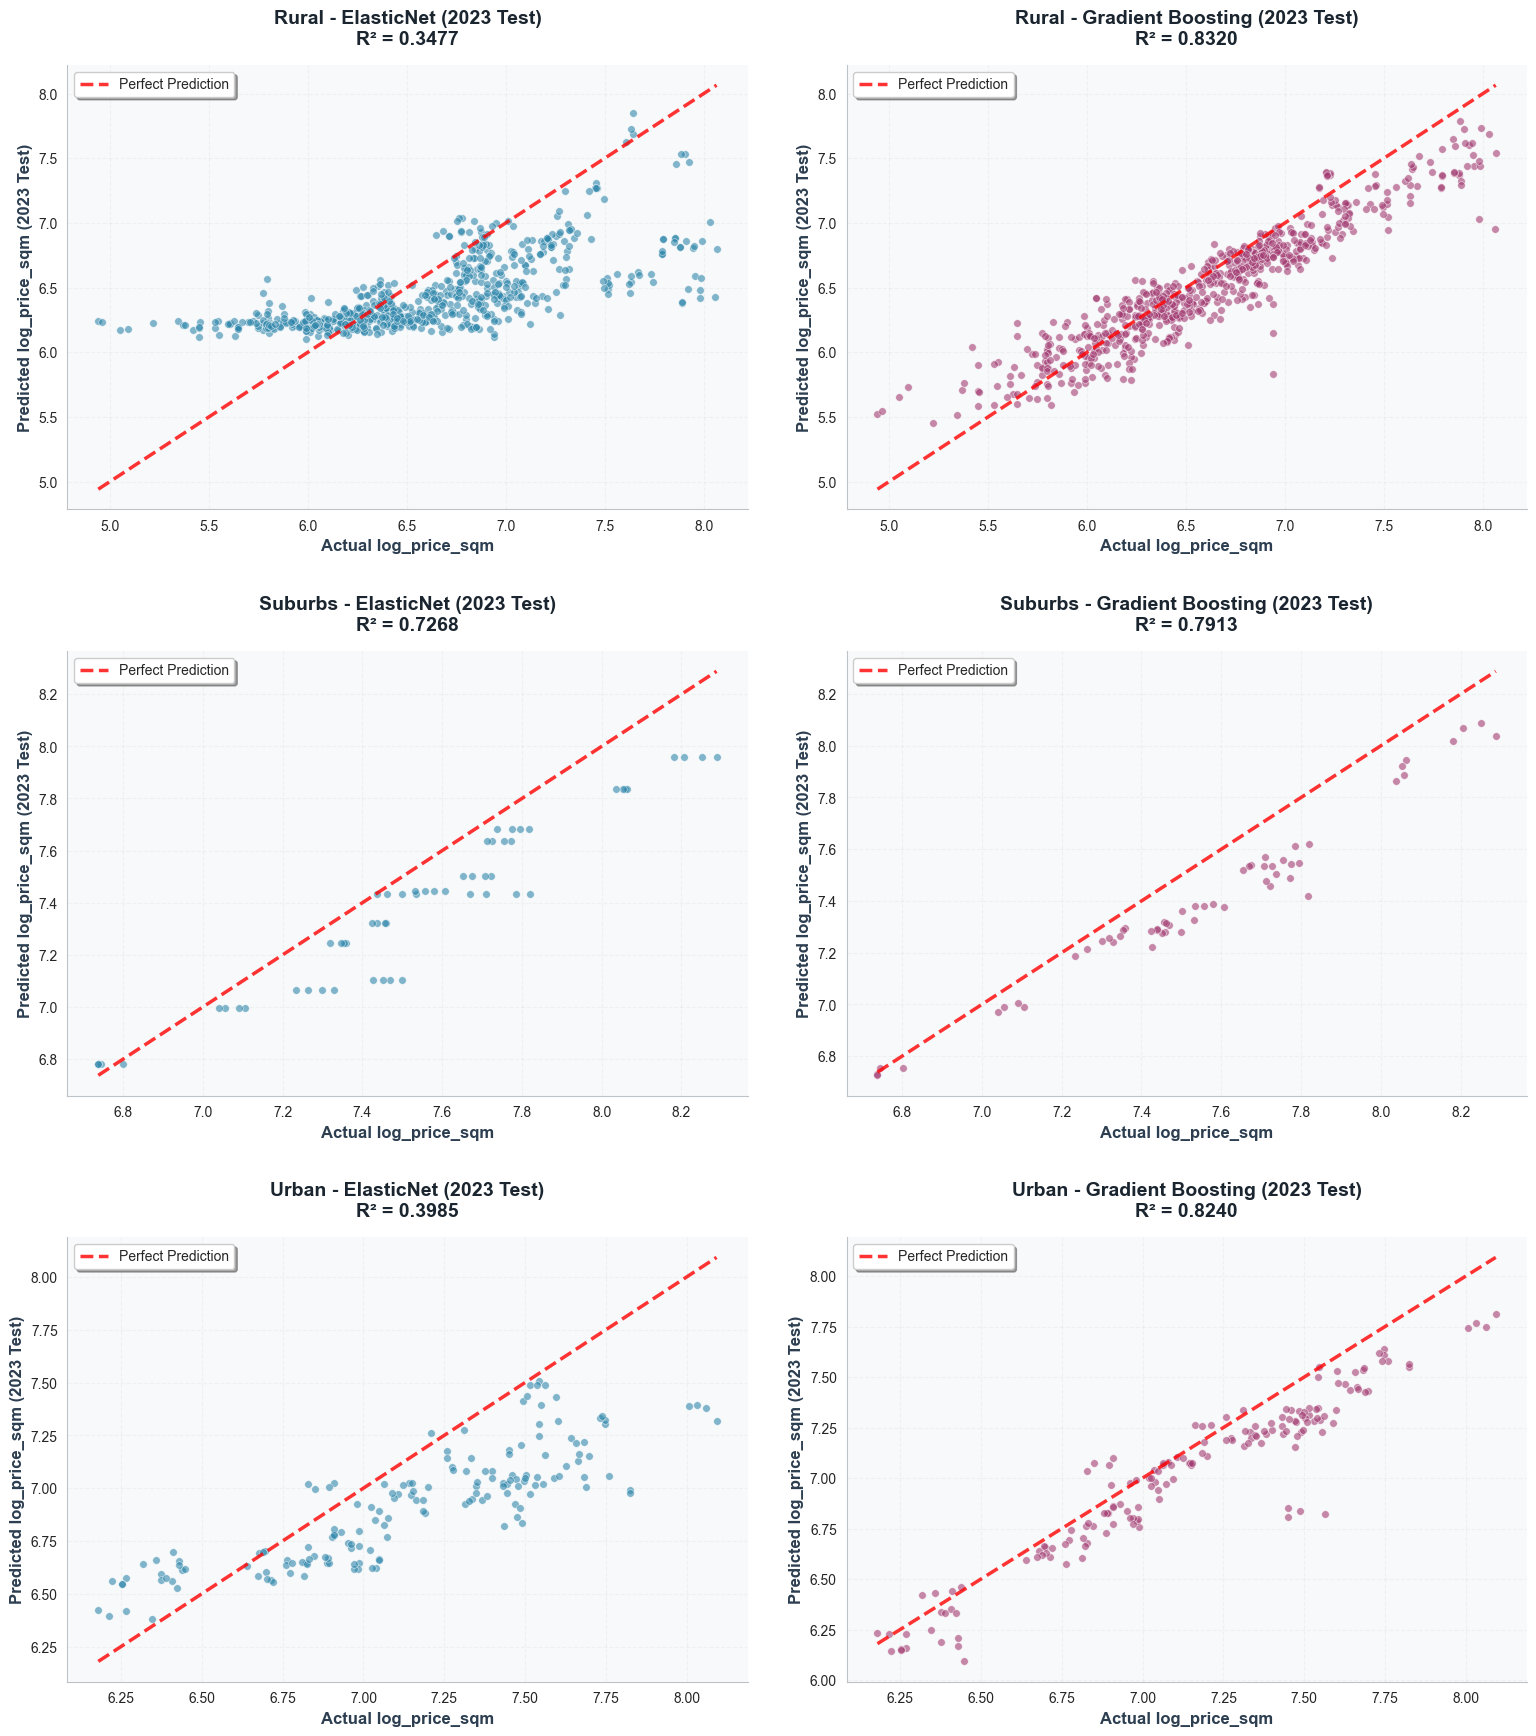

In [9]:
fig, axes = plt.subplots(len(selected_clusters), 2, figsize=(16, 6 * len(selected_clusters)))
fig.patch.set_facecolor('white')

if len(selected_clusters) == 1:
    axes = axes.reshape(1, -1)

for idx, cluster_id in enumerate(selected_clusters):
    if cluster_id not in cluster_results:
        continue
    
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")
    
    y_test = cluster_results[cluster_id]['elasticnet']['y_test']
    y_pred_en = cluster_results[cluster_id]['elasticnet']['y_pred']
    r2_en = cluster_results[cluster_id]['elasticnet']['test_r2']
    
    y_pred_gbm = cluster_results[cluster_id]['gbm']['y_pred']
    r2_gbm = cluster_results[cluster_id]['gbm']['test_r2']
    
    axes[idx, 0].scatter(y_test, y_pred_en, alpha=0.6, s=30, color='#2E86AB', 
                        edgecolors='white', linewidth=0.5)
    axes[idx, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                      'r--', linewidth=2.5, label='Perfect Prediction', alpha=0.8)
    axes[idx, 0].set_xlabel('Actual log_price_sqm', fontsize=12, fontweight='600', color='#2C3E50')
    axes[idx, 0].set_ylabel('Predicted log_price_sqm (2023 Test)', fontsize=12, fontweight='600', color='#2C3E50')
    axes[idx, 0].set_title(f'{cluster_label} - ElasticNet (2023 Test)\nR² = {r2_en:.4f}', 
                          fontsize=14, fontweight='bold', color='#1A252F', pad=15)
    axes[idx, 0].legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
    axes[idx, 0].grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
    axes[idx, 0].set_facecolor('#F8F9FA')
    axes[idx, 0].spines['top'].set_visible(False)
    axes[idx, 0].spines['right'].set_visible(False)
    axes[idx, 0].spines['left'].set_color('#BDC3C7')
    axes[idx, 0].spines['bottom'].set_color('#BDC3C7')
    
    axes[idx, 1].scatter(y_test, y_pred_gbm, alpha=0.6, s=30, color='#A23B72', 
                        edgecolors='white', linewidth=0.5)
    axes[idx, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                      'r--', linewidth=2.5, label='Perfect Prediction', alpha=0.8)
    axes[idx, 1].set_xlabel('Actual log_price_sqm', fontsize=12, fontweight='600', color='#2C3E50')
    axes[idx, 1].set_ylabel('Predicted log_price_sqm (2023 Test)', fontsize=12, fontweight='600', color='#2C3E50')
    axes[idx, 1].set_title(f'{cluster_label} - Gradient Boosting (2023 Test)\nR² = {r2_gbm:.4f}', 
                          fontsize=14, fontweight='bold', color='#1A252F', pad=15)
    axes[idx, 1].legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
    axes[idx, 1].grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
    axes[idx, 1].set_facecolor('#F8F9FA')
    axes[idx, 1].spines['top'].set_visible(False)
    axes[idx, 1].spines['right'].set_visible(False)
    axes[idx, 1].spines['left'].set_color('#BDC3C7')
    axes[idx, 1].spines['bottom'].set_color('#BDC3C7')

plt.tight_layout(pad=3.0)
plt.show()

## Understanding the feature importance

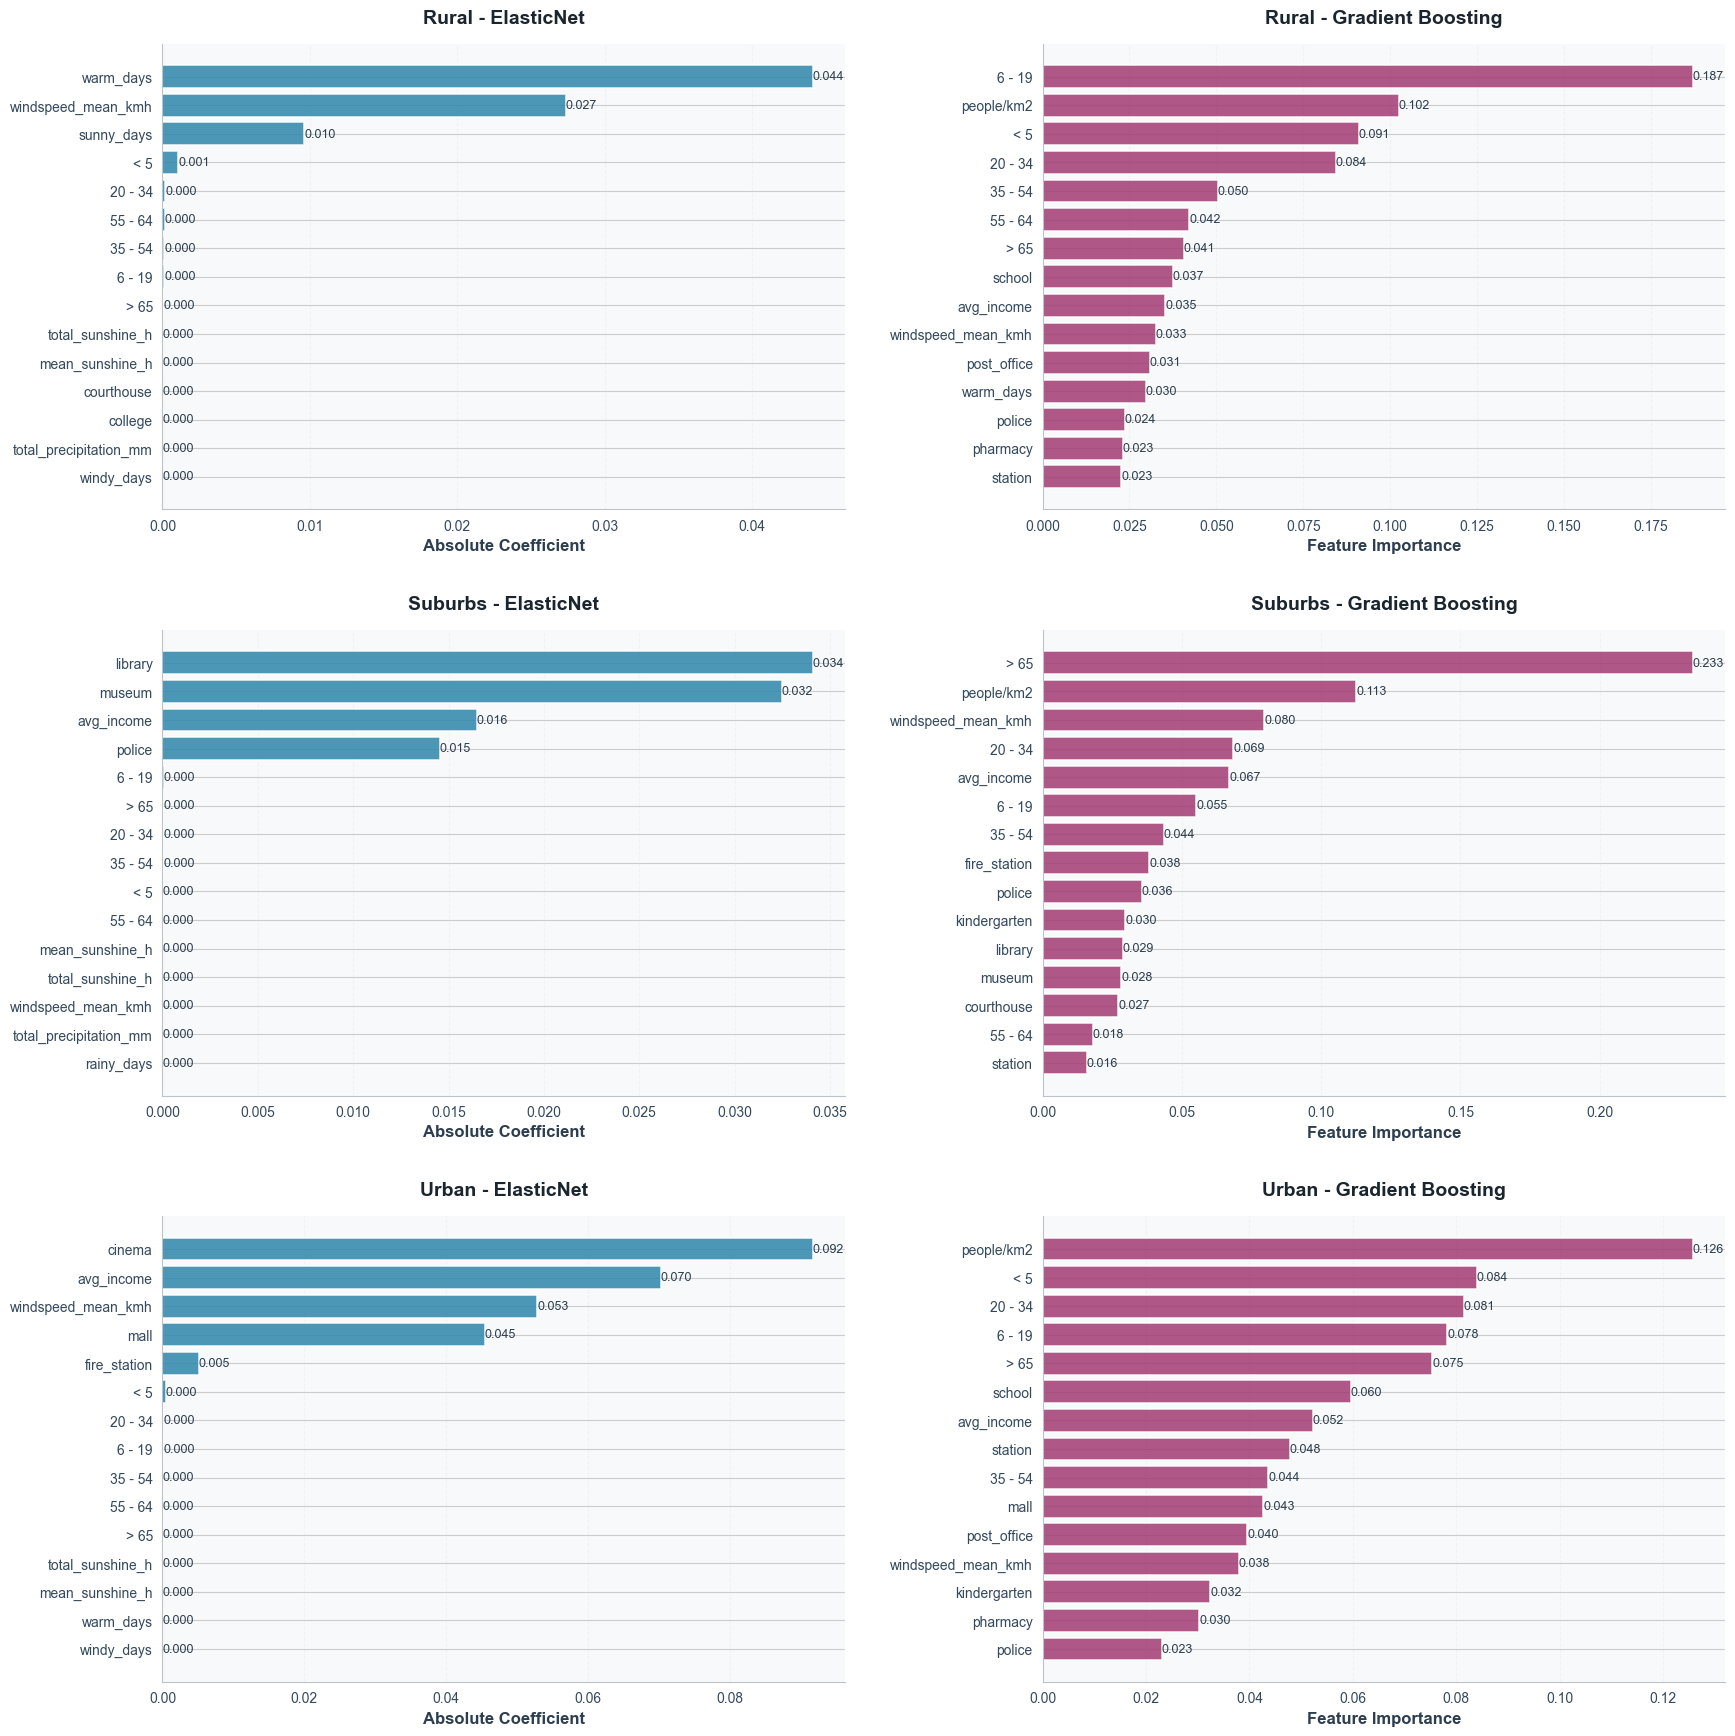

In [10]:
fig, axes = plt.subplots(len(selected_clusters), 2, figsize=(18, 6 * len(selected_clusters)))
fig.patch.set_facecolor('white')

if len(selected_clusters) == 1:
    axes = axes.reshape(1, -1)

color_elasticnet = '#2E86AB'
color_gbm = '#A23B72'

for idx, cluster_id in enumerate(selected_clusters):
    if cluster_id not in cluster_pipelines:
        continue
    
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")

    en_data = importance_df[
        (importance_df['Cluster ID'] == cluster_id) & 
        (importance_df['Model'] == 'elasticnet')
    ].sort_values('Importance', ascending=False).head(15)
    
    bars1 = axes[idx, 0].barh(en_data['Feature'], en_data['Importance'], 
                               color=color_elasticnet, alpha=0.85, edgecolor='white', linewidth=1.2)
    axes[idx, 0].set_xlabel('Absolute Coefficient', fontsize=12, fontweight='600', color='#2C3E50')
    axes[idx, 0].set_title(f'{cluster_label} - ElasticNet', fontsize=14, fontweight='bold', 
                           color='#1A252F', pad=15)
    axes[idx, 0].invert_yaxis()
    axes[idx, 0].grid(True, alpha=0.15, axis='x', linestyle='--', linewidth=0.8)
    axes[idx, 0].set_facecolor('#F8F9FA')
    axes[idx, 0].spines['top'].set_visible(False)
    axes[idx, 0].spines['right'].set_visible(False)
    axes[idx, 0].spines['left'].set_color('#BDC3C7')
    axes[idx, 0].spines['bottom'].set_color('#BDC3C7')
    axes[idx, 0].tick_params(axis='both', labelsize=10, colors='#34495E')
    
    for bar in bars1:
        width = bar.get_width()
        axes[idx, 0].text(width, bar.get_y() + bar.get_height()/2, 
                         f'{width:.3f}', ha='left', va='center', 
                         fontsize=9, color='#2C3E50', fontweight='500')
    
    gbm_data = importance_df[
        (importance_df['Cluster ID'] == cluster_id) & 
        (importance_df['Model'] == 'gbm')
    ].sort_values('Importance', ascending=False).head(15)
    
    bars2 = axes[idx, 1].barh(gbm_data['Feature'], gbm_data['Importance'], 
                              color=color_gbm, alpha=0.85, edgecolor='white', linewidth=1.2)
    axes[idx, 1].set_xlabel('Feature Importance', fontsize=12, fontweight='600', color='#2C3E50')
    axes[idx, 1].set_title(f'{cluster_label} - Gradient Boosting', fontsize=14, fontweight='bold', 
                           color='#1A252F', pad=15)
    axes[idx, 1].invert_yaxis()
    axes[idx, 1].grid(True, alpha=0.15, axis='x', linestyle='--', linewidth=0.8)
    axes[idx, 1].set_facecolor('#F8F9FA')
    axes[idx, 1].spines['top'].set_visible(False)
    axes[idx, 1].spines['right'].set_visible(False)
    axes[idx, 1].spines['left'].set_color('#BDC3C7')
    axes[idx, 1].spines['bottom'].set_color('#BDC3C7')
    axes[idx, 1].tick_params(axis='both', labelsize=10, colors='#34495E')
    
    for bar in bars2:
        width = bar.get_width()
        axes[idx, 1].text(width, bar.get_y() + bar.get_height()/2, 
                         f'{width:.3f}', ha='left', va='center', 
                         fontsize=9, color='#2C3E50', fontweight='500')

plt.tight_layout(pad=3.0)
plt.show()


In the Gradient Boosting Regressor, we can clearly see that one key factor drives house prices across the three different clusters — population density. This factor ranks near the top for suburban and rural areas and is the most influential feature in urban clusters. Another important variable is the age of the population, which plays a defining role in the model’s predictions. Additionally, the proximity to train stations is a noteworthy factor across all clusters, with a particularly strong effect in urban areas, likely because more residents rely on trains for commuting.

In contrast, the ElasticNet model reveals some distinct insights. In rural clusters, the most significant factor influencing house prices is actually weather conditions. Comparing these results with Gradient Boosting, we also notice that the presence of newborns is an important contributor, reinforcing the idea that it’s a genuine driving factor. Moreover, as we move closer to urban centers, average income becomes increasingly important (a trend also observed in the Gradient Boosting model). Finally, house prices in urban areas appear to be influenced by the presence of cultural amenities, highlighting the value people place on access to such places.

# Conclusion

There are many different factors that influence house prices in Portugal. However, the key takeaway from this analysis is that certain variables consistently stand out as the most important, regardless of location. These are population density, the presence of cultural amenities, weather conditions, and the average income of the area.